In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


In [2]:
DATA_PATH = "../data/loan_data.csv"
MODEL_PATH = "../models/loan_default_model.keras"
OUTPUT_DIR = "../outputs"

os.makedirs(OUTPUT_DIR, exist_ok=True)


In [3]:
df = pd.read_csv(DATA_PATH)
df.head()


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
nulls = df.isnull().sum()
print("Null Values:\n", nulls)

threshold = 0.5
df = df.loc[:, df.isnull().mean() < threshold]

numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])


Null Values:
 SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64


In [5]:
default_pct = df['TARGET'].value_counts(normalize=True) * 100
print("Default Distribution:\n", default_pct)


Default Distribution:
 TARGET
0    91.927118
1     8.072882
Name: proportion, dtype: float64


In [6]:
X = df.drop(columns=['TARGET'])
y = df['TARGET']

X = pd.get_dummies(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X_scaled, y)


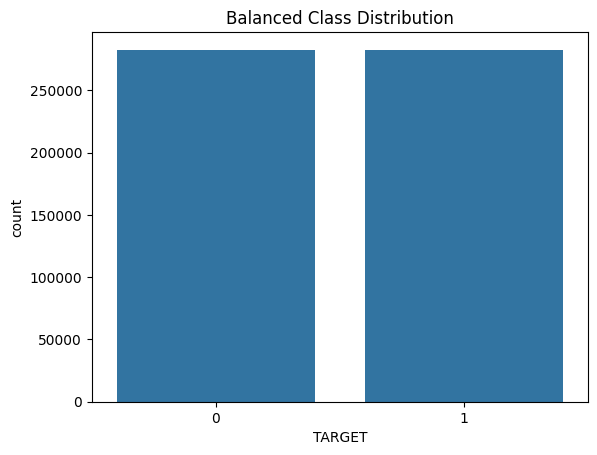

In [7]:
sns.countplot(x=y_bal)
plt.title('Balanced Class Distribution')
plt.savefig(f"{OUTPUT_DIR}/class_distribution.png")
plt.show()


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42)


In [9]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)


C:\Deep Learning Specialization\house_loan_analysis\venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
5654/5654 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.6901 - loss: 0.5928 - val_accuracy: 0.7495 - val_loss: 0.5127
Epoch 2/20
5654/5654 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.7460 - loss: 0.5181 - val_accuracy: 0.7821 - val_loss: 0.4720
Epoch 3/20
5654/5654 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - accuracy: 0.7660 - loss: 0.4886 - val_accuracy: 0.7929 - val_loss: 0.4469
Epoch 4/20
5654/5654 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.7766 - loss: 0.4715 - val_accuracy: 0.8049 - val_loss: 0.4317
Epoch 5/20
5654/5654 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.7851 - loss: 0.4581 - val_accuracy: 0.8131 - val_loss: 0.4187
Epoch 6/20
5654/5654 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.7926 - loss: 0.4441 - val_accuracy: 0.8180 - val_loss: 0.4082
Epoch 7/20
5654/5654 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.7979 - loss: 0.4359 - val_accuracy: 0.8251 - val_loss: 0.3951
Epoch 8/20
5654/5654 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.8035 - loss: 0

In [10]:
model.save(MODEL_PATH)

with open(f"{OUTPUT_DIR}/model_summary.txt", "w", encoding='utf-8') as f:
    model.summary(print_fn=lambda x: f.write(x + "\n"))


3534/3534 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


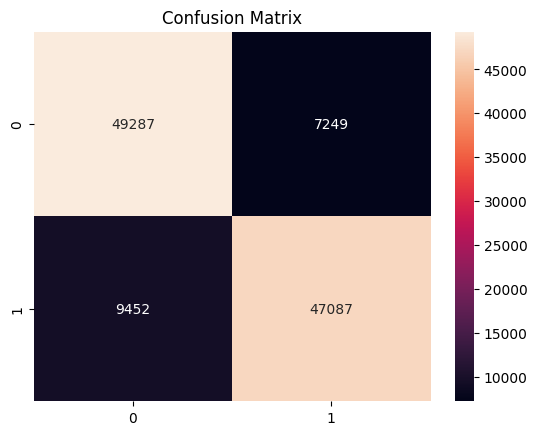

In [11]:
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.savefig(f"{OUTPUT_DIR}/confusion_matrix.png")
plt.show()


In [12]:
TP = cm[1, 1]
FN = cm[1, 0]
sensitivity = TP / (TP + FN)

auc = roc_auc_score(y_test, y_pred_probs)
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)


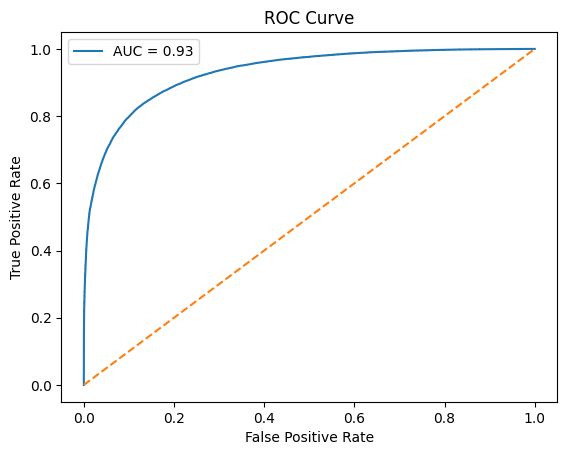

In [13]:
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.savefig(f"{OUTPUT_DIR}/roc_curve.png")
plt.show()


In [14]:
with open(f"{OUTPUT_DIR}/metrics.txt", "w") as f:
    f.write(f"Sensitivity: {sensitivity:.4f}\n")
    f.write(f"AUC: {auc:.4f}\n")

print("Model training and evaluation complete. Outputs saved.")


Model training and evaluation complete. Outputs saved.
